# 1. Importing modules and functions

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import chembl_structure_pipeline
from molvs import standardize_smiles
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

[05:34:24] Initializing Normalizer


# 2.Data entry and curation work set

In [2]:
uploaded_file_ws="datasets/HDAC3_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  1400 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [3]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [4]:
len(y_tr)

1400

# 3.Standardization SDF file for work set

In [5]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  1400 molecules


In [6]:
moldf_ws=pd.DataFrame(moldf_ws, columns=['Mol'])
moldf_ws

,Mol
0,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
1,<rdkit.Chem.rdchem.Mol object at 0x00000224543...
2,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
3,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
4,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
...,...
1395,<rdkit.Chem.rdchem.Mol object at 0x00000224192...
1396,<rdkit.Chem.rdchem.Mol object at 0x00000224192...
1397,<rdkit.Chem.rdchem.Mol object at 0x00000224192...
1398,<rdkit.Chem.rdchem.Mol object at 0x00000224192...


# 4.Data entry and curation test set

In [7]:
uploaded_file_ts="datasets/HDAC3_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  351 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [8]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [9]:
len(y_ts)

351

# 5.Standardization SDF file for test set

In [10]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  351 molecules


In [11]:
moldf_ts=pd.DataFrame(moldf_ts, columns=['Mol'])
moldf_ts

,Mol
0,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
1,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
2,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
3,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
4,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
...,...
346,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
347,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
348,<rdkit.Chem.rdchem.Mol object at 0x00000224172...
349,<rdkit.Chem.rdchem.Mol object at 0x00000224172...


# 6.Calculation MorganFingerprint for work set

In [12]:
def calcfp(mol,funcFPInfo=dict(radius=2, nBits=1024, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

# Training set
desc_ws = moldf_ws.Mol.apply(calcfp)
desc_ws

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1396,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1397,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1398,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
y_tr = np.array(y_tr, dtype=np.float32)
len(y_tr)

1400

# 7.Calculation MorganFingerprint for test set

In [14]:
desc_ts = moldf_ts.Mol.apply(calcfp)
desc_ts

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
347,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
348,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
349,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [15]:
y_ts = np.array(y_ts, dtype=np.float32)

# BASELINE

 ## GradientBoostingRegressor model building and validation

In [16]:
seed = 42

In [17]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [18]:
estimator = GradientBoostingRegressor(learning_rate=0.01,subsample= 0.5, n_estimators=1000, max_depth= 10,  random_state=seed)

In [19]:
estimator.fit(desc_ws, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [20]:
y_pred_CV_GBR = cross_val_predict(estimator, desc_ws, y_tr, cv=cv, n_jobs=-1)

In [21]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.69

In [22]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.68

# VarianceThreshold

In [23]:
from sklearn.feature_selection import VarianceThreshold

In [24]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [25]:
x_tr_const_and_nearcont=variance_threshold_selector(desc_ws, 0.05)
x_tr_const_and_nearcont

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
0,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1396,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1397,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1398,1,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [26]:
estimator.fit(x_tr_const_and_nearcont, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [27]:
y_pred_CV_GBR = cross_val_predict(estimator, x_tr_const_and_nearcont, y_tr, cv=cv, n_jobs=-1)

In [28]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.7

In [29]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.67

# Finding and removing duplicate features

In [30]:
def get_duplicates(X):
    pairs = {}
    dups = []
    for i in range(X.shape[1]):
        feat_outer = X.columns[i]
        if feat_outer not in dups:
           for feat_inner in X.columns[i + 1:]:
                if X[feat_outer].equals(X[feat_inner]):
                    pairs[feat_outer].append(feat_inner)
                    dups.append(feat_inner)
    result={}
    for key in  pairs:
        if len(pairs[key])>0:
            result[key]=pairs[key]     
    return result

In [31]:
get_duplicates(x_tr_const_and_nearcont)

{}

# Removing highly correlated features

In [32]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
Bit_1,1.000000,0.023343,0.060250,0.009891,0.011247,0.051526,0.056199,0.309418,0.204014,0.181086,...,0.111018,0.466243,0.044719,0.087555,0.194876,0.077911,0.311692,0.403763,0.021016,0.351924
Bit_4,0.023343,1.000000,0.027675,0.014926,0.037057,0.026979,0.016688,0.129453,0.123931,0.068172,...,0.079457,0.007767,0.014474,0.081022,0.017261,0.042160,0.065133,0.001191,0.028612,0.185722
Bit_8,0.060250,0.027675,1.000000,0.221732,0.042426,0.127507,0.114649,0.072877,0.168621,0.345448,...,0.158420,0.014074,0.089367,0.061572,0.364084,0.142961,0.153835,0.123936,0.095435,0.185521
Bit_14,0.009891,0.014926,0.221732,1.000000,0.070198,0.036017,0.057341,0.065951,0.071944,0.050997,...,0.077259,0.068002,0.088052,0.069185,0.086880,0.029150,0.072931,0.069101,0.029323,0.024528
Bit_15,0.011247,0.037057,0.042426,0.070198,1.000000,0.026488,0.101954,0.021461,0.008593,0.030356,...,0.075230,0.048196,0.158765,0.048643,0.004722,0.053132,0.059986,0.067215,0.083452,0.009351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bit_1009,0.077911,0.042160,0.142961,0.029150,0.053132,0.669497,0.724743,0.031466,0.005697,0.145736,...,0.003805,0.090313,0.006980,0.007684,0.077589,1.000000,0.021332,0.079413,0.382081,0.104191
Bit_1010,0.311692,0.065133,0.153835,0.072931,0.059986,0.003054,0.042885,0.226246,0.460361,0.145991,...,0.077332,0.486556,0.045322,0.187867,0.144834,0.021332,1.000000,0.750003,0.003429,0.272967
Bit_1016,0.403763,0.001191,0.123936,0.069101,0.067215,0.069502,0.025609,0.222045,0.515797,0.216998,...,0.075580,0.642871,0.047347,0.196146,0.128637,0.079413,0.750003,1.000000,0.015121,0.416002
Bit_1017,0.021016,0.028612,0.095435,0.029323,0.083452,0.202189,0.361635,0.070850,0.023592,0.096186,...,0.010623,0.018075,0.021782,0.012167,0.033495,0.382081,0.003429,0.015121,1.000000,0.027988


In [33]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
Bit_1,1.000000,0.023343,0.060250,0.009891,0.011247,0.051526,0.056199,0.309418,0.204014,0.181086,...,0.111018,0.466243,0.044719,0.087555,0.194876,0.077911,0.311692,0.403763,0.021016,0.351924
Bit_4,0.023343,1.000000,0.027675,0.014926,0.037057,0.026979,0.016688,0.129453,0.123931,0.068172,...,0.079457,0.007767,0.014474,0.081022,0.017261,0.042160,0.065133,0.001191,0.028612,0.185722
Bit_8,0.060250,0.027675,1.000000,0.221732,0.042426,0.127507,0.114649,0.072877,0.168621,0.345448,...,0.158420,0.014074,0.089367,0.061572,0.364084,0.142961,0.153835,0.123936,0.095435,0.185521
Bit_14,0.009891,0.014926,0.221732,1.000000,0.070198,0.036017,0.057341,0.065951,0.071944,0.050997,...,0.077259,0.068002,0.088052,0.069185,0.086880,0.029150,0.072931,0.069101,0.029323,0.024528
Bit_15,0.011247,0.037057,0.042426,0.070198,1.000000,0.026488,0.101954,0.021461,0.008593,0.030356,...,0.075230,0.048196,0.158765,0.048643,0.004722,0.053132,0.059986,0.067215,0.083452,0.009351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bit_1009,0.077911,0.042160,0.142961,0.029150,0.053132,0.669497,0.724743,0.031466,0.005697,0.145736,...,0.003805,0.090313,0.006980,0.007684,0.077589,1.000000,0.021332,0.079413,0.382081,0.104191
Bit_1010,0.311692,0.065133,0.153835,0.072931,0.059986,0.003054,0.042885,0.226246,0.460361,0.145991,...,0.077332,0.486556,0.045322,0.187867,0.144834,0.021332,1.000000,0.750003,0.003429,0.272967
Bit_1016,0.403763,0.001191,0.123936,0.069101,0.067215,0.069502,0.025609,0.222045,0.515797,0.216998,...,0.075580,0.642871,0.047347,0.196146,0.128637,0.079413,0.750003,1.000000,0.015121,0.416002
Bit_1017,0.021016,0.028612,0.095435,0.029323,0.083452,0.202189,0.361635,0.070850,0.023592,0.096186,...,0.010623,0.018075,0.021782,0.012167,0.033495,0.382081,0.003429,0.015121,1.000000,0.027988


In [34]:
mask=np.triu(np.ones_like(cor_df, dtype=bool))

In [35]:
tri_df=cor_df.mask(mask)
tri_df

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
Bit_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_4,0.023343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_8,0.060250,0.027675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_14,0.009891,0.014926,0.221732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bit_15,0.011247,0.037057,0.042426,0.070198,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bit_1009,0.077911,0.042160,0.142961,0.029150,0.053132,0.669497,0.724743,0.031466,0.005697,0.145736,...,0.003805,0.090313,0.006980,0.007684,0.077589,NaN,NaN,NaN,NaN,NaN
Bit_1010,0.311692,0.065133,0.153835,0.072931,0.059986,0.003054,0.042885,0.226246,0.460361,0.145991,...,0.077332,0.486556,0.045322,0.187867,0.144834,0.021332,NaN,NaN,NaN,NaN
Bit_1016,0.403763,0.001191,0.123936,0.069101,0.067215,0.069502,0.025609,0.222045,0.515797,0.216998,...,0.075580,0.642871,0.047347,0.196146,0.128637,0.079413,0.750003,NaN,NaN,NaN
Bit_1017,0.021016,0.028612,0.095435,0.029323,0.083452,0.202189,0.361635,0.070850,0.023592,0.096186,...,0.010623,0.018075,0.021782,0.012167,0.033495,0.382081,0.003429,0.015121,NaN,NaN


In [36]:
to_drop=[c for c in tri_df.columns if any(tri_df[c]>0.95) ]
to_drop

['Bit_109', 'Bit_238', 'Bit_331', 'Bit_607']

In [37]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [38]:
reduced_df_cor

,Bit_1,Bit_4,Bit_8,Bit_14,Bit_15,Bit_25,Bit_31,Bit_33,Bit_36,Bit_41,...,Bit_967,Bit_971,Bit_980,Bit_997,Bit_999,Bit_1009,Bit_1010,Bit_1016,Bit_1017,Bit_1019
0,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1396,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1397,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,1
1398,1,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [39]:
estimator.fit(reduced_df_cor, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [40]:
y_pred_CV_GBR = cross_val_predict(estimator, reduced_df_cor, y_tr, cv=cv, n_jobs=-1)

In [41]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.7

In [42]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.67

In [43]:
feature_name_reduced_df_cor = reduced_df_cor.columns.tolist()
len(feature_name_reduced_df_cor)

205

# Prediction for test set's molecules

In [44]:
x_ts=desc_ts[feature_name_reduced_df_cor]

In [45]:
y_ts = np.array(y_ts, dtype=np.float32)

In [46]:
y_pred_GBR = estimator.predict(x_ts)

In [50]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.71

In [49]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.66

# Permutation-importance

In [799]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [834]:
sel = SelectFromModel(PermutationImportance(GradientBoostingRegressor(), cv=cv),threshold=0.005,).fit(reduced_df_cor, y_tr)

In [835]:
X_permut_import = sel.transform(reduced_df_cor)
X_permut_import.shape

(1400, 33)

In [836]:
feature_idx = sel.get_support()
feature_name = reduced_df_cor.columns[feature_idx]
feature_name 

Index(['Bit_36', 'Bit_90', 'Bit_117', 'Bit_119', 'Bit_128', 'Bit_197',
       'Bit_229', 'Bit_243', 'Bit_250', 'Bit_301', 'Bit_389', 'Bit_408',
       'Bit_419', 'Bit_486', 'Bit_494', 'Bit_511', 'Bit_549', 'Bit_559',
       'Bit_638', 'Bit_662', 'Bit_708', 'Bit_714', 'Bit_721', 'Bit_726',
       'Bit_736', 'Bit_759', 'Bit_831', 'Bit_843', 'Bit_852', 'Bit_878',
       'Bit_910', 'Bit_922', 'Bit_955'],
      dtype='object')

In [837]:
estimator.fit(X_permut_import, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [838]:
y_pred_CV_GBR = cross_val_predict(estimator, X_permut_import, y_tr, cv=cv, n_jobs=-1)

In [839]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.59

In [840]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.78

# Prediction for test set's molecules

In [841]:
x_ts=desc_ts[feature_name]

In [842]:
y_ts = np.array(y_ts, dtype=np.float32)

In [843]:
y_pred_GBR = estimator.predict(x_ts)

In [844]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.64

In [845]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.74

 # Recursive feature elimination

In [862]:
from sklearn.feature_selection import RFECV
estimator

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [863]:
rfecv = RFECV(estimator=estimator, cv=cv, scoring='r2')
rfecv.fit(reduced_df_cor, y_tr)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                          n_estimators=1000, random_state=42,
                                          subsample=0.5),
      scoring='r2')

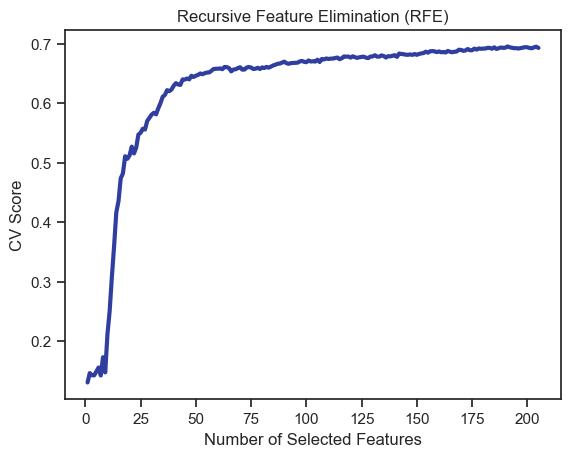

The optimal number of features: 191


In [864]:
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()
print("The optimal number of features: {}".format(rfecv.n_features_))

Make a new DataFrame called "X_rfe" that contains selected features.

In [868]:
reduced_df_cor = np.array(reduced_df_cor, dtype=np.float32)

In [869]:
X_rfe = reduced_df_cor[:, rfecv.support_]

In [870]:
X_rfe.shape

(1400, 191)

In [871]:
estimator.fit(X_rfe, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [872]:
y_pred_CV_GBR = cross_val_predict(estimator, X_rfe, y_tr, cv=cv, n_jobs=-1)

In [873]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.7

In [874]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.67

In [878]:
feature_idx = rfecv.get_support()
feature_name_rfecv = reduced_df_cor.columns[feature_idx]
feature_name_rfecv

Index(['Bit_1', 'Bit_4', 'Bit_8', 'Bit_15', 'Bit_25', 'Bit_31', 'Bit_33',
       'Bit_36', 'Bit_41', 'Bit_42',
       ...
       'Bit_961', 'Bit_967', 'Bit_980', 'Bit_997', 'Bit_999', 'Bit_1009',
       'Bit_1010', 'Bit_1016', 'Bit_1017', 'Bit_1019'],
      dtype='object', length=191)

# Prediction for test set's molecules

In [879]:
x_ts=desc_ts[feature_name_rfecv]

In [880]:
y_ts = np.array(y_ts, dtype=np.float32)

In [881]:
y_pred_GBR = estimator.predict(x_ts)

In [882]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.71

In [883]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.66

# Sequential Feature Selector

In [51]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [52]:
sfs = SFS(estimator, 
           k_features=50, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           n_jobs=2,
           cv=cv)


sfs = sfs.fit(reduced_df_cor, y_tr)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 205 out of 205 | elapsed:  5.7min finished

[2024-11-13 05:43:41] Features: 1/50 -- score: 0.18139096121440157[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   59.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 204 out of 204 | elapsed:  5.3min finished

[2024-11-13 05:49:02] Features: 2/50 -- score: 0.23409518291391765[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 203 out of 203 | elapsed:  5.9min finished

[2024-11-13 05:54:55] Features: 3/50 -- score: 0.264593635832376

In [53]:
X_train_sfs = sfs.transform(reduced_df_cor)

In [59]:
X_test_sfs = sfs.transform(desc_ts)

In [54]:
estimator.fit(X_train_sfs, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [55]:
y_pred_CV_GBR = cross_val_predict(estimator, X_train_sfs, y_tr, cv=cv, n_jobs=-1)

In [56]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.72

In [57]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.64

In [61]:
X_test_sfs.shape

(351, 50)

# Prediction for test set's molecules

In [62]:
y_pred_ts = estimator.predict(X_test_sfs)

In [63]:
Q2_TS = round(r2_score(y_ts, y_pred_ts), 2)
Q2_TS

-0.83

In [64]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_ts)), 2)
RMSE_TS

1.66